<a href="https://colab.research.google.com/github/JacopoKahl/gan_mnist/blob/main/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Generative Adversial Network

Fully-connected networks (generator and discriminator) as thew original implementation (2014)

Example on the MNIST dataset

##Imports

In [1]:
#Keras imports
from keras.models import Sequential #Sequential model 
from keras.layers import Dense, Dropout

from keras.layers.advanced_activations import LeakyReLU #advanced LeakyRelu activation layer

#Dataset
from keras.datasets import mnist

import numpy as np #import numpy library

#Visualization 
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model

##Load data

In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data() #load dataset

#Normalization of the dataset
X_train = (X_train.astype(np.float32) - 127.5) /127.5 #normaliza pixel values in the [-1,1] interval
X_test = (X_test.astype(np.float32) - 127.5) /127.5 #normaliza pixel values in the [-1,1] interval

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
print(X_train.shape)

(60000, 28, 28)


##Reshape input image into 1D array

We need to feed the input to fully connected network

In [4]:
#Save original dimension before reshaping

num_Samples = X_train.shape[0]
rows = X_train.shape[1]
cols = X_train.shape[2]

X_train = X_train.reshape(num_Samples, rows*cols)
print(X_train.shape)

(60000, 784)


##Models 

###Network parameters

In [5]:
gen_InputDim = 100 #Generator input dimension (like strating from the latent space)


##Generator

The generator architecture is like a decoder in the autoencoder.

In [6]:
generator = Sequential()

generator.add(Dense(units=256, input_dim= gen_InputDim))
generator.add(LeakyReLU(0.2)) #LeakyRealu with reduced alpha (slope of the negative segment) wrt default parameter

generator.add(Dense(units=512))
generator.add(LeakyReLU(0.2)) #LeakyRealu with reduced alpha (slope of the negative segment) wrt default parameter

generator.add(Dense(units=1024))
generator.add(LeakyReLU(0.2)) #LeakyRealu with reduced alpha (slope of the negative segment) wrt default parameter

generator.add(Dense(units=X_train.shape[1], activation = 'tanh')) #tanh activation returns values in the [-1,1] interval


In [7]:
generator.compile(loss='binary_crossentropy', optimizer='adam')
generator.summary()
#plot_model(generator)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               8

##Discriminator 

The discriminator is an image classifier. The output is binary: 1(true) for original image nd 0 for fakes (generated by the generator).

In [8]:
discriminator = Sequential() #Sequential model

discriminator.add(Dense(units=1024, input_dim=generator.output_shape[1]))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

discriminator.add(Dense(units=512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))

discriminator.add(Dense(units=256))
discriminator.add(LeakyReLU(0.2))

discriminator.add(Dense(units=1, activation='sigmoid')) #1 output unit for binary classification

In [9]:
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

##Gan

In [10]:
gan = Sequential()

gan.add(generator)
gan.add(discriminator)

gan.compile(loss='binary_crossentropy', optimizer='adam')

gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 784)               1486352   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 2,946,577
Non-trainable params: 0
_________________________________________________________________


##Training

The training is the hardest part for Gans.

The process is very parameter dependent and notoriously difficult to tune.
The training process itself is articulated as it requires alternate training of the generator and the discriminator to allow for strong models to be trained.
The discriminator will be trained separately on batches of real and fake images (from the generator).
Training of the generator will require to attach it to the discriminator (as we have nothing for judging the output of the generator). The fake images will be fed to the discriminator and the only way to improve for the generator will be to see if the fake images are able to fool the discriminator (ideal objective would be to have discriminator accuracy = 0.5). **Please note that we will need to freese the discriminator's weights when we train the generator**

In [12]:
#Define a function for visualizing the images that the generator is able to generate

def plot_generated_images(epoch, gen, inputDim, numSamples=100, dim=(10,10), figureSize=(10,10)):
  #epoch: epoch number
  #gen: instance of the generator to use for generating the images
  #numSamples: number of images to be generated
  #inputDim: dimension of the input vectors
  #dim: size in pixels of each image in the figure
  #figureSize: size in inches of the whole figure

  #Generate images via the generator
  noise = np.random.normal(loc=0, scale=1, size=[numSamples, inputDim]) #generate random input vectors. Each of them has gen_InputDim dimensions. Each vector is like a "noisy" zero vector with 100 components.
  gen_images = gen.predict(noise) #images produced by the generator

  gen_images = gen_images.reshape(numSamples, rows, cols) #reshape images produced by the generator to their 2D aspect

  #Visualiza images
  plt.figure(figsize=figureSize) #create whole figure place-holder
  for i in range(numSamples): #for all subfigures
    plt.subplot(dim[0], dim[1], i+1) #create place-holder for i-th subfigure
    plt.imshow(gen_images[i], cmap='gray') #plot the i-th image in gen_images in the place-holder created above
    plt.axis('off') #disable coordinate system axis

  plt.savefig('gen_images %d.png' %epoch) #save image with the epoch number in the filename

In [14]:
#Defining a function for all training instructions

def training(epochs=1, batch_size=128):
  batch_count = int(num_Samples / batch_size) #number of batches

  for e in range (1, epochs+1): #epochs counter starts from 1
    print('Epochs: ', e)
    for _ in range (batch_count):
      #generate input vectors from the generator
      noise = np.random.normal(loc=0, scale=1, size=[batch_size, gen_InputDim]) #generate random input vestors. Each of them has gen_InputDim dimensions.

      #generate fake images batch by feeding vectors to the generator
      generated_images = generator.predict(noise) #the generator produces an image for each input vector

      #generate batch of real images from dataset
      dataset_batch = X_train[np.random.randint(low=0, high=X_train.shape[0], size=batch_size)]

      #compose together fake and real images in a single batch
      X_batch = np.concatenate([dataset_batch, generated_images])

      #create label vectors
      Y_batch = np.zeros(batch_size*2) #create a zero vector with batch_size*2 components

      #TRAIN discriminator
      discriminator.trainable = True #set training flag to True to allow modification of weights in the training process
      discriminator.train_on_batch(X_batch, Y_batch) #train_on_batch trains the model on a given batch.

      #TRAIN generator (by training on the whole gan model)
      noise = np.random.normal(loc=0, scale=1, size=[batch_size, gen_InputDim]) #generate random input vectors. Each of them has gen_InputDim dimensions.
      Y_noise = np.ones(batch_size) #label "1" for the fake images in order to "trick" the discriminator and get the distance between the label and the discriminator's output
      discriminator.trainable = False #training flag to false to disable weight modification to the discriminator
      gan.train_on_batch(noise, Y_noise) #train the gan with discriminator wieghts frozen
    
    if e==1 or e%10==0: #every 10 eppochs (+ the first one)
      plot_generated_images(e, generator, gen_InputDim) #generate new images

Epochs:  1
Epochs:  2
Epochs:  3
Epochs:  4
Epochs:  5
Epochs:  6
Epochs:  7
Epochs:  8
Epochs:  9
Epochs:  10


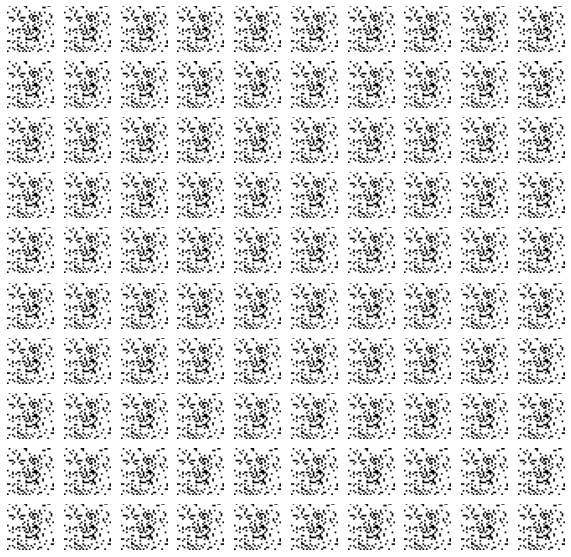

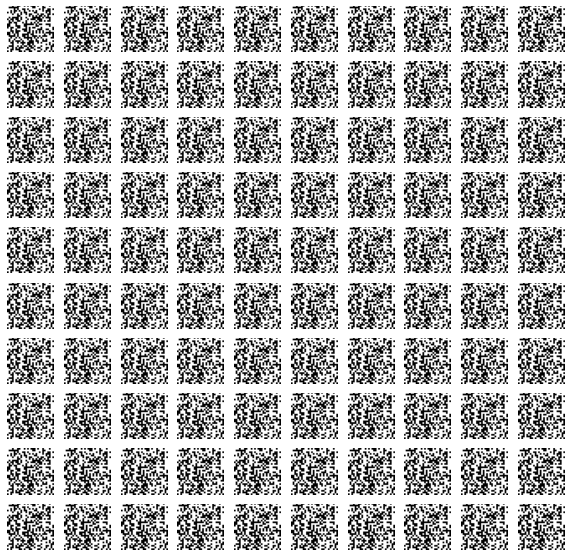

In [15]:
training(epochs=10, batch_size=128)